# Notebook 02 - Data Cleaning

## Objectives

* Check data for duplicate entries
* Determine whether there is any missing data
* For any columns that contain missing data, determine how best to handle the missing data
* Assess whether any data needs to have its type changed or be aggregated or renamed
* Clean data
* Develop a data cleaning pipeline for use on future data provided by the client

## Inputs

* CSV file generated in previous notebook: outputs/datasets/collection/house_price_records.csv

## Outputs

* Cleaned data, to be stored in new folder outputs/datasets/cleaned/v1
* Data cleaning pipeline

## [Conclusions]

* [Conclusions here]

---

# Import Packages

In [24]:
import os
import pandas as pd
from ydata_profiling import ProfileReport
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer, ArbitraryNumberImputer

# Change working directory

* This notebook is stored in the `jupyter_notebooks` subfolder
* The current working directory therefore needs to be changed to the workspace, i.e., the working directory needs to be changed from the current folder to its parent folder

Firstly, the current directory is accessed with os.getcwd()

In [2]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\franc\\housing-price-predictor\\jupyter_notebooks'

Next, the working directory is set as the parent of the current `jupyter_notebooks` directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory
* This allows access to all the files and folders within the workspace, rather than solely those within the `jupyter_notebooks` directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Finally, confirm that the new current directory has been successfully set

In [4]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\franc\\housing-price-predictor'

---

# Load Data

The data is loaded from the outputs/datasets/collection folder:

In [5]:
df = pd.read_csv('outputs/datasets/collection/house_price_records.csv')
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

# Data Examination

## Check for duplicate entries

Firstly, we want to check the data for any duplicate entries.
* There is no unique identifier field in this dataset.
* This means that we cannot check a single field for duplicates using code such as `df[df.duplicated(subset='ID')]` but will need to consider multiple columns.
    - For example, it is highly likely that two different houses will appear in the dataset that have the same value for, say, `1stFlrSF`
* Even considering all columns, it is theoretically entirely possible (albeit somewhat unlikely) that two different houses in this dataset could have identical values for all features.
* However, if we find that this does not occur we can confirm that there are no duplicate values.

In [6]:
duplicates = (df.duplicated(keep=False)*1).sum()
print(duplicates)

0


We see that there are no two identical rows in the dataset and therefore we can assume that there are no duplicate records included in the dataset.

## Check for missing data

We can already see from the data that is loaded above that a number of variables have missing data. We can confirm which variables these are and the extent of missing data as follows:

In [7]:
vars_with_missing_data = df.columns[df.isna().sum() > 0]

missing_data_table = pd.DataFrame({
    'Variable': vars_with_missing_data,
    'Number Missing': df[vars_with_missing_data].isna().sum(),
    'Percentage Missing': (df[vars_with_missing_data].isna().mean() * 100).round(1),
    'Data Type': df[vars_with_missing_data].dtypes
}).sort_values(by='Percentage Missing', ascending=False).reset_index(drop=True)

print(missing_data_table)

        Variable  Number Missing  Percentage Missing Data Type
0  EnclosedPorch            1324                90.7   float64
1     WoodDeckSF            1305                89.4   float64
2    LotFrontage             259                17.7   float64
3   GarageFinish             162                11.1    object
4   BsmtFinType1             114                 7.8    object
5   BedroomAbvGr              99                 6.8   float64
6       2ndFlrSF              86                 5.9   float64
7    GarageYrBlt              81                 5.5   float64
8     MasVnrArea               8                 0.5   float64


From this we see straight away that `EnclosedPorch` and `WoodDeckSF` have very high proportions of missing values, with 90.7% and 89.4% respectively.
* With such a high proportion of missing values, it may be the case that these variables cannot be expected to have significant predictive power and will need to be dropped from the dataset.
* However, it seems more likely that the missing values simply reflect the absence of a porch or a wood deck respectively in these properties
* Some other variables with apparently missing data might also be explained in a similar way. For example, could missing values of `2ndFlrSF` indicate that there is no second floor in these properties and `GarageYrBlt` the absence of a garage?
* Other variables such as `LotFrontage` seem quite unlikely to be explained in this manner. 
* We also see that some of the variables with missing data have a data type of `float64`, while others are `object`: that is, categorical data.

To gain further insight into the remaining variables with missing data, we can create a Pandas profile report for these variables only:

In [8]:
profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From the Pandas report we see that `BedroomAbvGr` and `LotFrontage` appear somewhat close to a normal distribution, and therefore we may be able to use mean imputation for these variables. The remainder of the numerical variables, `2ndFlrSF`, `GarageYrBlt` and `MasVnrArea`, do not appear to be normally distributed and so median imputation is likely to be more appropriate. `GarageFinish` and `BsmtFinType1` are categorical variables and as such will require categorical imputation.

First, we can examine the numerical variables more closely by plotting larger histograms than those in the Pandas profile report, and that have KDE lines. Following this, we check whether these variables are in fact normally distributed:

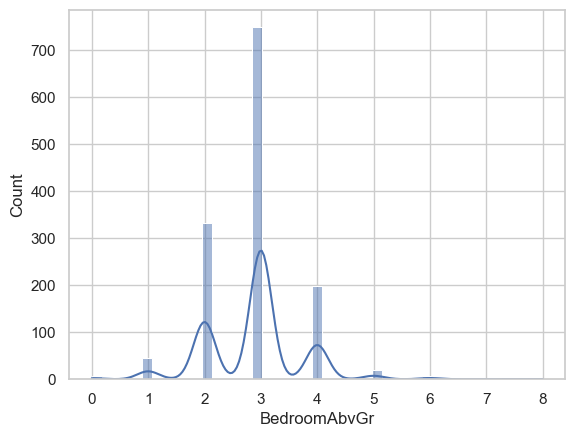

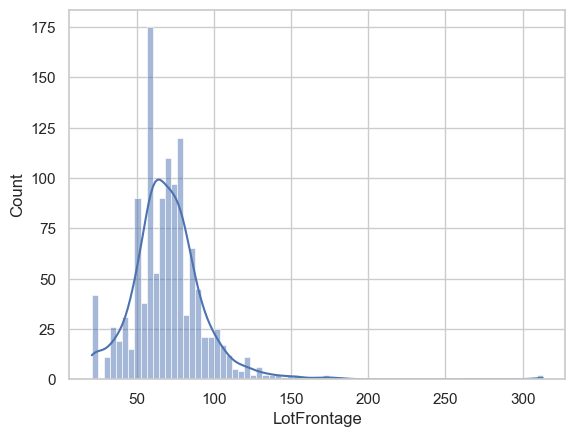

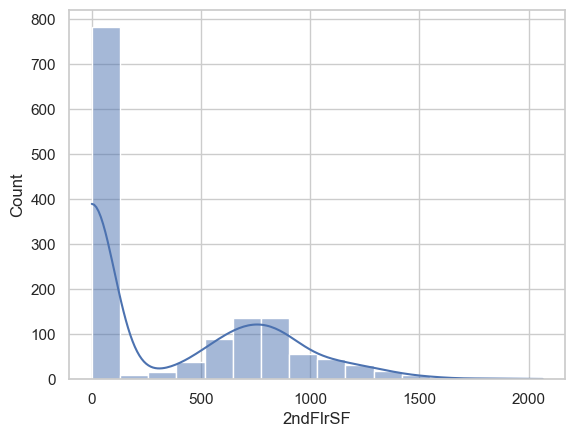

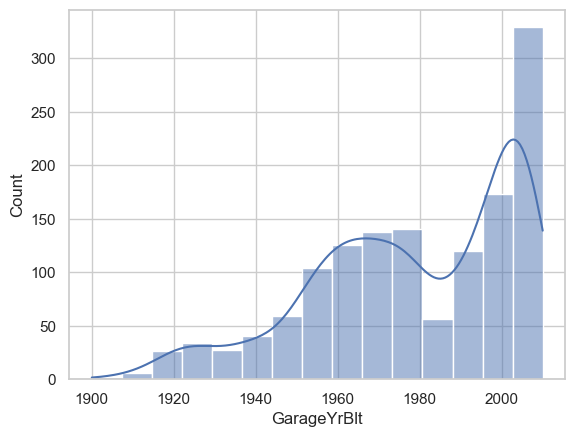

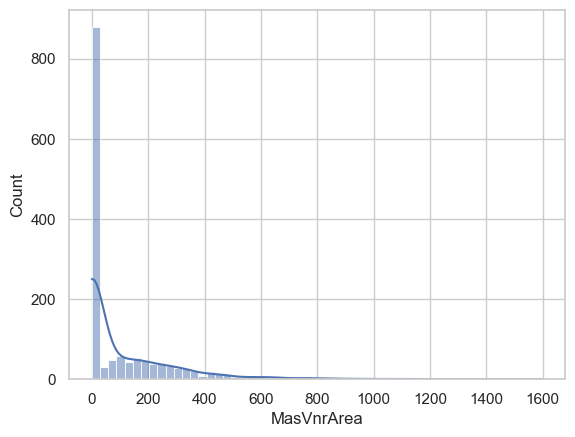

In [9]:
vars_to_check_for_normality = ['BedroomAbvGr', 'LotFrontage', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea']
for var in vars_to_check_for_normality:
    sns.histplot(data=df, kde=True, x=var)
    plt.show()

We use the Shapiro-Wilk test from the `scipy.stats` module to check for normality more accurately than we can do by examining the data visually:

In [10]:
alpha = 0.05

for var in vars_to_check_for_normality:
    data = df[var].dropna()
    stat, p = stats.shapiro(data)
    if p > alpha:
        print(f"{var}: Data is normally distributed.")
    else:
        print(f"{var}: Data is not normally distributed.")

BedroomAbvGr: Data is not normally distributed.
LotFrontage: Data is not normally distributed.
2ndFlrSF: Data is not normally distributed.
GarageYrBlt: Data is not normally distributed.
MasVnrArea: Data is not normally distributed.


We see that despite some variables appearing close to a normal distribution, none of the variables is in fact normally distributed and hence median imputation will be more appropriate for all variables.

Note from [Medium](https://medium.com/swlh/missing-data-imputation-in-feature-engineering-aeefd03ba58d) that ideally we should only use median imputation when the following conditions are met:
* Data is missing completely at random ("MCAR")
* No more than 5% of the variable contains missing data

We have no way of verifying whether the missing data in this dataset is truly random, and we know for certain that for all of the relevant variables except `MasVnrArea`, more than 5% of the variable contains missing data. However, the same article also notes that "although in theory, the above conditions should be met to minimize the impact of this imputation technique, in practice, mean/median imputation is very commonly used, even in those cases when data is not MCAR and there are a lot of missing values. The reason behind this is the simplicity of the technique."
* We can therefore go ahead with median imputation here, while noting this as a potential limitation of the method.

Before we do this, let's revisit our list of variables with missing data, and assess which are likely to be explained by absence of the feature they relate to, rather than genuinely missing data.

In [11]:
vars_with_missing_data

Index(['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinType1', 'EnclosedPorch',
       'GarageFinish', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea',
       'WoodDeckSF'],
      dtype='object')

Taking these one by one:
* `2ndFlrSF` is the square footage of the second floor. There are no other variables in the dataset that explicitly relate to the second floor of a property that we can use to cross-check the presence of a second floor in that property. However, it might be reasonable to consider whether properties with no second floor would be cheaper than those that do have a second floor, since they are likely to be smaller. We can look at the `SalePrice` for these properties; if they have a significantly below average sale price, this might suggest that this is in fact the case.

In [12]:
df_missing_2ndFlrSF = df[df['2ndFlrSF'].isna()]
mean_saleprice_all = df['SalePrice'].mean().round()
stdev_saleprice_all = df['SalePrice'].std().round()
mean_saleprice_missing_2ndFlrSF = df_missing_2ndFlrSF['SalePrice'].mean().round()
print(f"Mean sale price for all properties: {mean_saleprice_all}")
print(f"Mean sale price for properties missing 2ndFlrSF: {mean_saleprice_missing_2ndFlrSF}")
print(f"Standard deviation of sale price for all properties: {stdev_saleprice_all}")

Mean sale price for all properties: 180921.0
Mean sale price for properties missing 2ndFlrSF: 174932.0
Standard deviation of sale price for all properties: 79443.0


These values seem close, with the average sale price for properties missing `2ndFlrSF` well within one standard deviation of the average sale price for all properties.

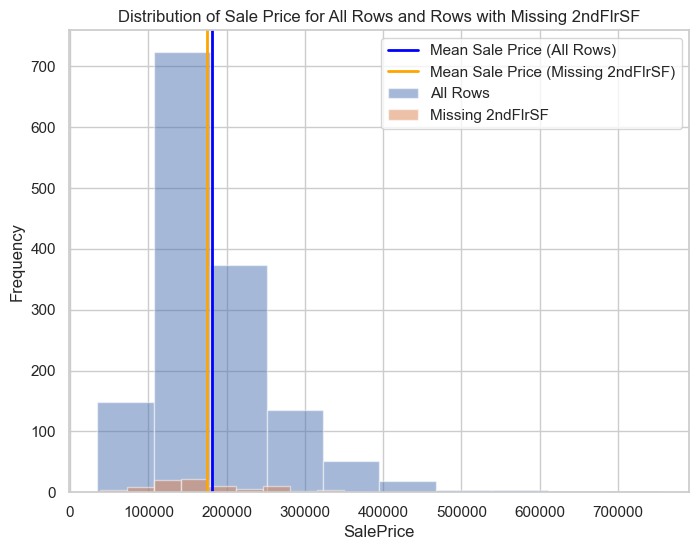

In [13]:
plt.figure(figsize=(8, 6))
plt.hist(df['SalePrice'], bins=10, alpha=0.5, label='All Rows')
plt.hist(df_missing_2ndFlrSF['SalePrice'], bins=10, alpha=0.5, label='Missing 2ndFlrSF')
plt.axvline(x=mean_saleprice_all, color='blue', linewidth=2, label='Mean Sale Price (All Rows)')
plt.axvline(x=mean_saleprice_missing_2ndFlrSF, color='orange', linewidth=2, label='Mean Sale Price (Missing 2ndFlrSF)')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Sale Price for All Rows and Rows with Missing 2ndFlrSF')
plt.show()

Again, we see visually that the two lines representing the mean sale price of all houses and the mean sale price of houses without recorded values for `2ndFlrSF` are very close. We can also see that the distribution for both of these is similar, with the majority falling into the second bin for both sets and then tailing off above this. In the absence of any evidence that this relates to properties without a second floor, then, we will use median imputation for this variable.

`BedroomAbvGr` relates to the number of bedrooms above ground level that a given property has.
* There is a note in the data that this "does NOT include basement bedrooms" - so it is in theory possible that a house could contain only basement bedrooms.
* This seems quite unlikely in practice, and again if it were the case it would probably mean that these houses would have a lower-than-average sale price.
* We can perform similar calculations for `BedroomAbvGr` to the ones we did above for `2ndFlrSF`:

In [14]:
df_missing_BedroomAbvGr = df[df['BedroomAbvGr'].isna()]
mean_saleprice_all = df['SalePrice'].mean().round()
stdev_saleprice_all = df['SalePrice'].std().round()
mean_saleprice_missing_BedroomAbvGr = df_missing_BedroomAbvGr['SalePrice'].mean().round()
print(f"Mean sale price for all properties: {mean_saleprice_all}")
print(f"Mean sale price for properties missing BedroomAbvGr: {mean_saleprice_missing_BedroomAbvGr}")
print(f"Standard deviation of sale price for all properties: {stdev_saleprice_all}")

Mean sale price for all properties: 180921.0
Mean sale price for properties missing BedroomAbvGr: 191144.0
Standard deviation of sale price for all properties: 79443.0


These houses have a higher mean sale price than the average, making it extremely unlikely that the missing data relates to properties that do not have above-ground bedrooms. As such, we will use median imputation for this variable also.

`BsmtFinType1` is the rating of the basement finished area. We can cross-check this against `BsmtExposure`, since the latter does not have any values appearing as missing:

In [15]:
bsmtfintype1_counts = df['BsmtFinType1'].value_counts(dropna=False)
bsmtexposure_counts = df['BsmtExposure'].value_counts(dropna=False)

print(f"BsmtFinType1 counts: \n{bsmtfintype1_counts}")
print(f"BsmtExposure counts: \n{bsmtexposure_counts}")

BsmtFinType1 counts: 
Unf     396
GLQ     385
ALQ     202
BLQ     136
Rec     126
NaN     114
LwQ      70
None     31
Name: BsmtFinType1, dtype: int64
BsmtExposure counts: 
No      953
Av      221
Gd      134
Mn      114
None     38
Name: BsmtExposure, dtype: int64


We see from this comparison that `BsmtExposure` has 38 values of `None` (i.e., the property has no basement), while `BsmtFinType1` has 31 values of `None` and 114 missing values. The missing values in `BsmtFinType1` cannot, then, be explained by lack of a basement in these properties.
* However, looking at the counts of different values for `BsmtFinType1`, we see that the most frequently occurring is `Unf` or Unfinished, very closely followed by `GLQ`, Good Living Quarters. These are opposite extremes from one another and occur with almost equal frequency. In this scenario, it seems that it might be better to code missing data as `Missing` in order to be sure to avoid introducing bias or finding a pattern that is not in fact present.

Next we have `EnclosedPorch`, which together with `WoodDeckSF` we suspect might have a large number of values appearing as missing that would actually be more appropriately recorded as zeroes, due to the absence of a porch or a wooden deck respectively in these properties.
* We can compare the average sale price of houses with these values missing to that of the dataset as a whole.
* We might expect them to have slightly lower sale prices than average if this hypothesis is correct, since these features would be presumed to add to the value, although there may be other confounding factors at play that we are unaware of (does presence of an enclosed porch mean that there is less likely to be an open porch, for example?).

In [16]:
df_missing_EnclosedPorch = df[df['EnclosedPorch'].isna()]
mean_saleprice_all = df['SalePrice'].mean().round()
stdev_saleprice_all = df['SalePrice'].std().round()
mean_saleprice_missing_EnclosedPorch = df_missing_EnclosedPorch['SalePrice'].mean().round()
print(f"Mean sale price for all properties: {mean_saleprice_all}")
print(f"Mean sale price for properties missing EnclosedPorch: {mean_saleprice_missing_EnclosedPorch}")
print(f"Standard deviation of sale price for all properties: {stdev_saleprice_all}")

Mean sale price for all properties: 180921.0
Mean sale price for properties missing EnclosedPorch: 180268.0
Standard deviation of sale price for all properties: 79443.0


In [17]:
df_missing_WoodDeckSF = df[df['WoodDeckSF'].isna()]
mean_saleprice_all = df['SalePrice'].mean().round()
stdev_saleprice_all = df['SalePrice'].std().round()
mean_saleprice_missing_WoodDeckSF = df_missing_WoodDeckSF['SalePrice'].mean().round()
print(f"Mean sale price for all properties: {mean_saleprice_all}")
print(f"Mean sale price for properties missing WoodDeckSF: {mean_saleprice_missing_WoodDeckSF}")
print(f"Standard deviation of sale price for all properties: {stdev_saleprice_all}")

Mean sale price for all properties: 180921.0
Mean sale price for properties missing WoodDeckSF: 181186.0
Standard deviation of sale price for all properties: 79443.0


For both `EnclosedPorch` and `WoodDeckSF`, the sale price of properties with these values missing is very close to the average for all properties; this does not help us make a decision. Given this result and the large proportions of missing values, we suspect that these variables will in any case have little or no predictive power, and will therefore drop them from the dataset at this point.

We will consider the two variables relating to garages together: `GarageFinish` and `GarageYrBlt`. We note that these have 162 and 81 missing values respectively, with 73 and no zero values recorded respectively.
* We can compare these to `GarageArea`, which does not have any values showing as missing, to try to understand whether some of the missing values for these variables relate to properties without garages.

In [18]:
num_zeroes = (df['GarageArea'] == 0).sum()

print(f"Number of zeroes in GarageArea: {num_zeroes}")

Number of zeroes in GarageArea: 81


Excellent - the number of zeroes in `GarageArea` exactly matches the number of missing values in `GarageYrBlt`.
* We can assume that the missing values in `GarageYrBlt` relate to properties without a garage, and code these as 0.
The treatment of `GarageFinish` is slightly more complex; we proceed as follows:
* 73 of the values in `GarageFinish` are recorded as zero, so these will be left as zeroes.
* For the 163 values recorded as missing, we might expect 8 of these to be zero, since the number of 73 recorded zeroes is less than the 81 recorded zeroes in `GarageArea`.
    - It would be most appropriate to fill in 0 for the examples of `GarageFinish` where `GarageArea` is also zero, and impute with the most frequently occurring category for the remainder.
    - However, for simplicity, we will impute all 163 missing values with the most frequently occurring category here. If this appears to be an issue at a later stage, this decision could be revisited at that point.

Finally, we have `LotFrontage` and `MasVnrArea`.
* `LotFrontage` does not contain any zeroes in the data, and this seems unlikely as a value since it relates to the linear feet of the street connected to the property. As such, we can use median imputation for this variable.
* `MasVnrArea`, or the masonry veneer area in square feet, has very few (8) missing values. Since this feature as a whole has 861 or 59.0% zeroes, we might suspect that the missing values are also zeroes. We have no way of verifying this and so should use median imputation, although in practice both will give the same results, since with a dataset that is over 50% zeroes, the median must by definition also be zero.

---

# Data Cleaning Evaluation

## Data Cleaning Effect function to evaluate the impact of the data cleaning

We want to assess the impact of the data cleaning processes on the dataset. To do this, we can use the following function, which is coped and adapted from Code Institute's Feature Engine lessons, unit 9.

In [22]:
def data_cleaning_effect(df_original,df_cleaned,variables_applied_with_method):
  """
  Function to visualise data cleaning effect
  """
  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first show the variables that the method is being applied to
    # then, for numerical variables, plot a histogram; for categorical variables, plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is a categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig, axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is a numerical variable: histogram

        fig, axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

## Summary of data cleaning steps

To summarise the discussion above, the data cleaning steps will be as follows:

Use median imputation on the following variables:
* `2ndFlrSF`
* `BedroomAbvGr`
* `LotFrontage`
* `MasVnrArea`

Code missing values as 'Missing' for the following variable:
* `BsmtFinType1`

Code missing values as zero for the following variable:
* `GarageYrBlt`

Impute missing values with the most frequently occurring category for the following variable:
* `GarageFinish`

Drop the following variables:
* `EnclosedPorch`
* `WoodDeckSF`

## Split the train and test sets

The train and test sets must be split before data cleaning is applied to the train set that will be used to train the model. This avoids the potential for data leakage, whereby information about the test dataset, which will be used to evaluate model performance, is available to the model during training.
* For example, if we used median imputation on the whole dataset before splitting it into the train and test sets, this median value would also represent the data in the test set, whereas we want it to be solely based on the training set to avoid biasing the model.

However, we will also clean the full dataset for our correlation and PPS analyses and evaluation of hypotheses, since these do not feed into the modelling.

In [25]:
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


## Apply the data cleaning steps to the train set

### 1. Median Imputation

Variables:
* `2ndFlrSF`
* `BedroomAbvGr`
* `LotFrontage`
* `MasVnrArea`

---

# Data Cleaning Pipeline

To summarise the sections above, the steps to be undertaken within the data cleaning pipeline are:

Use median imputation on the following variables:
* `2ndFlrSF`
* `BedroomAbvGr`
* `LotFrontage`
* `MasVnrArea`

Code missing values as 'Missing' for the following variable:
* `BsmtFinType1`

Code missing values as zero for the following variable:
* `GarageYrBlt`

Impute missing values with the most frequently occurring category for the following variable:
* `GarageFinish`

Drop the following variables:
* `EnclosedPorch`
* `WoodDeckSF`

In [19]:
data_cleaning_pipeline = Pipeline([
    ('median', MeanMedianImputer(imputation_method='median',
                                 variables=['2ndFlrSF', 'BedroomAbvGr',
                                 'LotFrontage', 'MasVnrArea']) ),
    ('categorical_missing', CategoricalImputer(imputation_method='missing',
                                     fill_value='Missing',
                                     variables=['BsmtFinType1']) ),
    ('garage_absent', ArbitraryNumberImputer(arbitrary_number=0,
                                               variables=['GarageYrBlt'])),
    ('categorical_frequent', CategoricalImputer(imputation_method='frequent',
                                     variables=['GarageFinish']) ),
    ('drop',  DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF']) )  
])

---

---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [21]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)


IndentationError: expected an indented block (2852421808.py, line 5)